# Image analysis for a complete area captured by Clemex

For image '20250312_Nickel_02_00' which is the worst.    
The porosiy from imagej is 0.90.    


Aim: 
- Read in the full image from the google drive 
- convert the image to UINT8 
- Segment the a single sample from the background 
- Segment the pores from the base material 
- Get the ratio of pores to solid material

In [1]:
# Set up the module for the porosity_analysis packages  

import os 
import sys 

Pyro_module  = '../20250312_PorosityAnalysis/porosity_analysis'
# Add the parent directory of Pyro_DataAnalysis to the system path
if os.path.exists(Pyro_module) == True:
    sys.path.insert(0, os.path.abspath(Pyro_module))
else :
    print('The file does not exist')

In [2]:
# import statements 

#import statements 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import os 

import numpy as np

from skimage.filters import difference_of_gaussians,gaussian
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops,regionprops_table ,find_contours
from skimage.color import label2rgb
import matplotlib.patches as mpatches
import imageio.v3 as iio

import config 
import custom_funcs 
import image_analysis as ia
from pathlib import Path

import cv2

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 3019898880

In [4]:
# Google drive location 
experimental_dir = config.technical_dir_path

In [5]:
threshold_csv = os.path.join(experimental_dir,'data/processed/global_threshold.csv')
df_threshold = pd.read_csv(threshold_csv)
df_threshold['Designation'] = '0'+ df_threshold['Designation'].astype(str)
df_threshold['Material_Designation'] = df_threshold['date'].astype(str) + '_' +  df_threshold['Material'] + '_' +  df_threshold['Designation']

In [6]:
df_threshold

,ref_im,date,Material,Designation,Otsu,Material_Designation
0,20250219_Nickel_04_thresh.png,20250219,Nickel,04,0.420488,20250219_Nickel_04
1,20250310_Nickel_02_00_thresh.png,20250310,Nickel,02,0.534619,20250310_Nickel_02
2,20250310_Nickel_01_thresh.png,20250310,Nickel,01,0.537771,20250310_Nickel_01
3,20250310_Nickel_05_thresh.png,20250310,Nickel,05,0.528401,20250310_Nickel_05
4,20250310_Nickel_04_thresh.png,20250310,Nickel,04,0.534359,20250310_Nickel_04
5,20250310_Nickel_03_thresh.png,20250310,Nickel,03,0.535766,20250310_Nickel_03
6,20250219_Nickel_03_thresh.png,20250219,Nickel,03,0.420022,20250219_Nickel_03
7,20250312_Nickel_02_thresh.png,20250312,Nickel,02,0.528459,20250312_Nickel_02
8,20250312_Nickel_01_thresh.png,20250312,Nickel,01,0.401673,20250312_Nickel_01


### Image preparation:

- All the images shoud be cropped using Fiji/Image-J to show only relevant part 
- All images should be saved as .png's or .tifs    
More details on the sample labelling is on the explainer.

In [7]:
# Image directory ---->
processed_ImagDir = Path("data/processed")
# Google drive location for the all cropped images
Processed_ImagDir_loc = experimental_dir / processed_ImagDir
print(f'This is the list of all the images in the processed data directory: {os.listdir(Processed_ImagDir_loc)}')

This is the list of all the images in the processed data directory: ['thresholding', '20250219_Nickel_03_00.png', '20250219_Nickel_03_10.png', '20250219_Nickel_04_00.png', '20250219_Nickel_04_10.png', '20250310_Nickel_02_00.png', '20250310_Nickel_02_01.png', '20250310_Nickel_01_01.png', '20250310_Nickel_01_00.png', '20250310_Nickel_01_10.png', '20250310_Nickel_01_11.png', '20250310_Nickel_05_00.png', '20250310_Nickel_05_01.png', '20250310_Nickel_04_01.png', '20250310_Nickel_04_00.png', '20250310_Nickel_04_10.png', '20250310_Nickel_04_11.png', '20250310_Nickel_03_00.png', '20250310_Nickel_03_10.png', '20250312_Nickel_01_00.png', '20250312_Nickel_01_01.png', '20250312_Nickel_02_00.png', '20250312_Nickel_02_01.png', '20250312_Nickel_02_10.png', '20250312_Nickel_02_11.png', 'global_threshold.csv', 'npy_cache']


### Find the .npy for the part 

In [121]:
key = '20250312_Nickel_02_00'

In [122]:
npy_file = Path( 'G:/Shared drives/Instruct3d/Technical/Experiment and case study campaign Q1 2025/Exp 2 - Thermal & Sensor Fusion/data/processed/npy_cache/20250312_Nickel_02_00.npy')
os.path.exists(npy_file)

True

In [123]:
## read .npy file 
npy_data = {}

with open(npy_file, 'rb') as f:
    npy_data[key] = np.load(f)  # Store in dictionary with filename as key
npy_data.keys()


dict_keys(['20250312_Nickel_02_00'])

In [124]:
df = pd.DataFrame(columns= ['File','Date','Material','Designation','Sample_label','Otsu','denisty/%'])
for key in npy_data:
    parts = key.split("_")

    
    Date = parts[0]
    Material = parts[1]
    Designation = parts[2]
    Sample_label = parts[3]

    # Append to DataFrame
    df = pd.concat([df, pd.DataFrame([{'File': key,'Date':Date,'Material': Material, 'Designation': Designation, 'Sample_label': Sample_label}])], ignore_index=True)

df['Material_Designation'] = df['Date'].astype(str) + '_' +  df['Material'] + '_' +  df['Designation']
df

,File,Date,Material,Designation,Sample_label,Otsu,denisty/%,Material_Designation
0,20250312_Nickel_02_00,20250312,Nickel,02,00,NaN,NaN,20250312_Nickel_02


In [125]:
df = pd.merge(df, df_threshold[['Material_Designation', 'Otsu']], on='Material_Designation', how='left').drop(columns='Otsu_x')
df.rename(columns={"Otsu_y": "Otsu"}, inplace= True)
df


,File,Date,Material,Designation,Sample_label,denisty/%,Material_Designation,Otsu
0,20250312_Nickel_02_00,20250312,Nickel,02,00,NaN,20250312_Nickel_02,0.528459


In [126]:
# Get the Otsu threshold from the threshold df 
temp_key = key[:-3]
Otsu = df.loc[df.Material_Designation == temp_key,'Otsu'].values[0]

tower = npy_data[key]
print(tower)

[[[165 169 189]
  [158 162 184]
  [162 165 183]
  ...
  [192 203 220]
  [192 203 223]
  [193 204 228]]

 [[170 172 197]
  [162 165 190]
  [166 170 192]
  ...
  [193 202 222]
  [191 202 222]
  [188 200 224]]

 [[170 171 196]
  [164 167 193]
  [165 168 194]
  ...
  [192 200 221]
  [193 201 220]
  [192 201 220]]

 ...

 [[198 205 232]
  [202 209 230]
  [205 218 240]
  ...
  [190 200 225]
  [193 203 225]
  [193 201 223]]

 [[201 210 231]
  [205 216 234]
  [204 214 241]
  ...
  [190 201 220]
  [190 202 226]
  [187 199 219]]

 [[205 213 241]
  [207 213 236]
  [203 208 228]
  ...
  [194 203 225]
  [193 204 222]
  [189 200 223]]]


the shape of the image is (3366, 4386) and the image size is 14763276 and the datatype is uint8


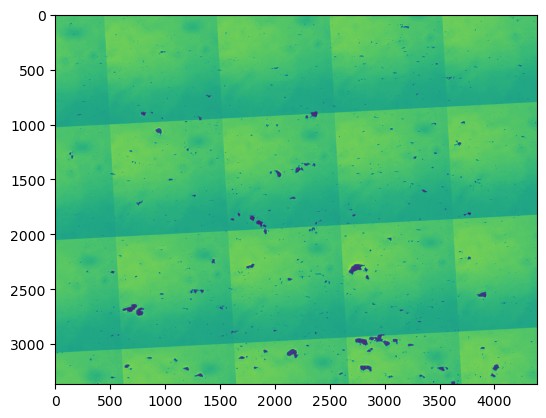

In [127]:
### read the image 
img_png =  'G:/Shared drives/Instruct3d/Technical/Experiment and case study campaign Q1 2025/Exp 2 - Thermal & Sensor Fusion/data/processed/20250312_Nickel_02_00.png'
img_np_array = np.array(iio.imread(img_png))  # Read image and convert to NumPy array
img_gray = np.round(img_np_array).astype(np.uint8)[:,:,0]
plt.imshow(img_gray)
print(f"the shape of the image is {img_gray.shape} and the image size is {img_gray.size} and the datatype is {img_gray.dtype}")

(array([3.690000e+03, 9.107000e+04, 2.310900e+04, 1.704500e+04,
        1.935900e+04, 1.394669e+06, 5.689048e+06, 7.445089e+06,
        7.179000e+04, 8.407000e+03]),
 array([ 36. ,  57.9,  79.8, 101.7, 123.6, 145.5, 167.4, 189.3, 211.2,
        233.1, 255. ]),
 <BarContainer object of 10 artists>)

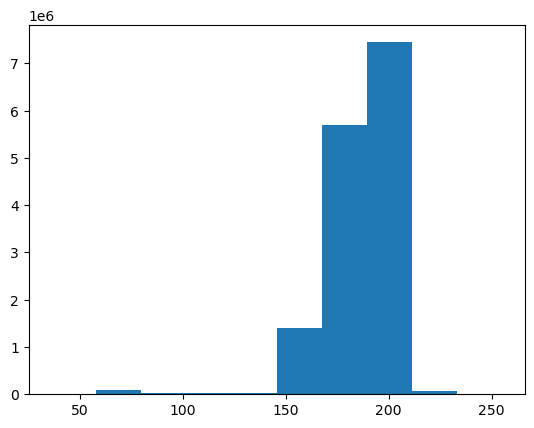

In [128]:
counts, bins = np.histogram(img_gray)
plt.hist(bins[:-1], bins, weights=counts)

the shape of the image is (3366, 4386) and the image size is 14763276 and the datatype is bool


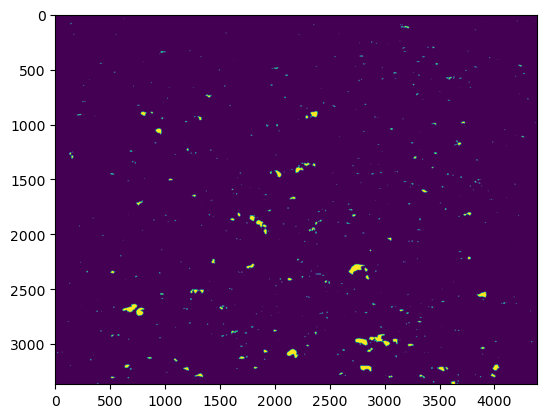

In [129]:
image_blur = gaussian(img_gray,2)
image_threshold = image_blur < Otsu
plt.imshow(image_threshold)
print(f"the shape of the image is {image_threshold.shape} and the image size is {image_threshold.size} and the datatype is {image_threshold.dtype}")

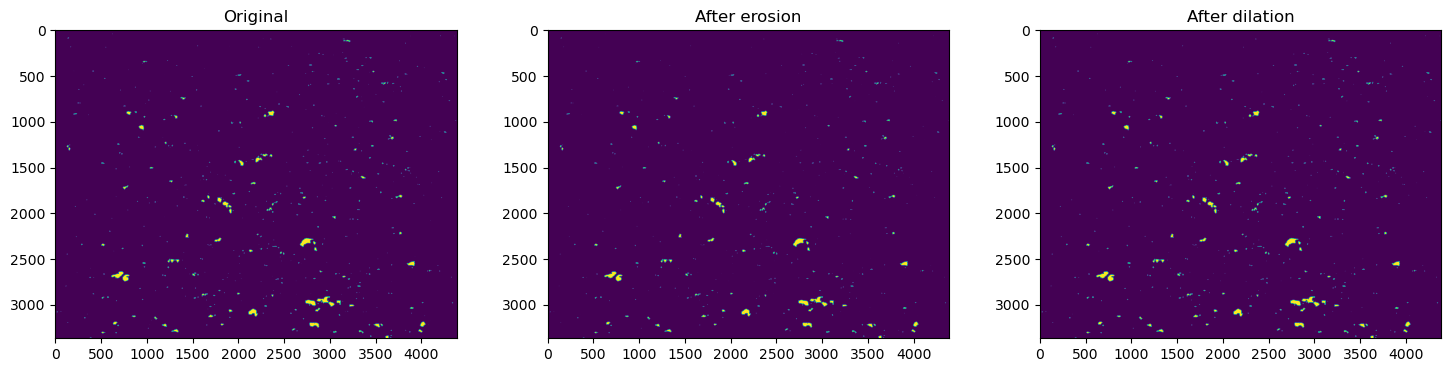

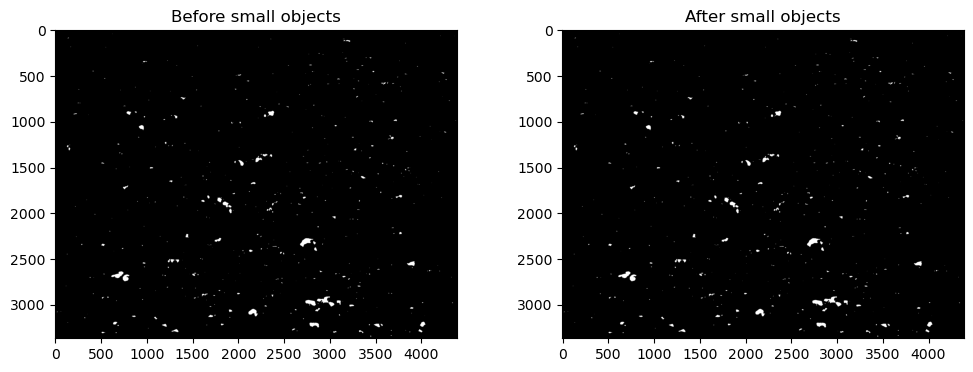

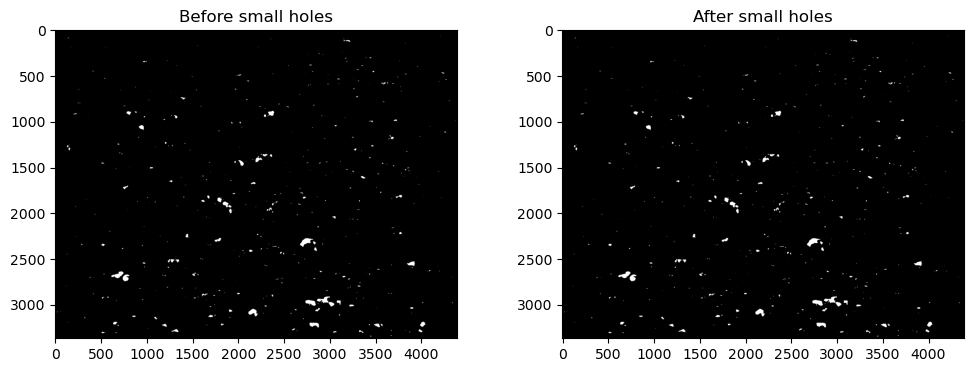

In [130]:
# morphological tidying
image_eroded_dilated = ia.erosion_dilation_loop(image_threshold, 1, 1, True)
# remove artifacts connected to image border
cleared = clear_border(image_eroded_dilated)
image_small_objects = ia.clean_small_objects(cleared,1, True) # 100
image_small_holes = ia.clean_small_holes(image_small_objects,1, True) # 100

In [149]:
image_small_holes
100*(1 - (np.count_nonzero(image_small_holes, axis=None))/image_small_holes.size)



99.20006914454488

In [114]:
save_fig_Dir = Path("figures/density_images")

In [ ]:
label_image = label(image_small_holes)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


99.20006914454488

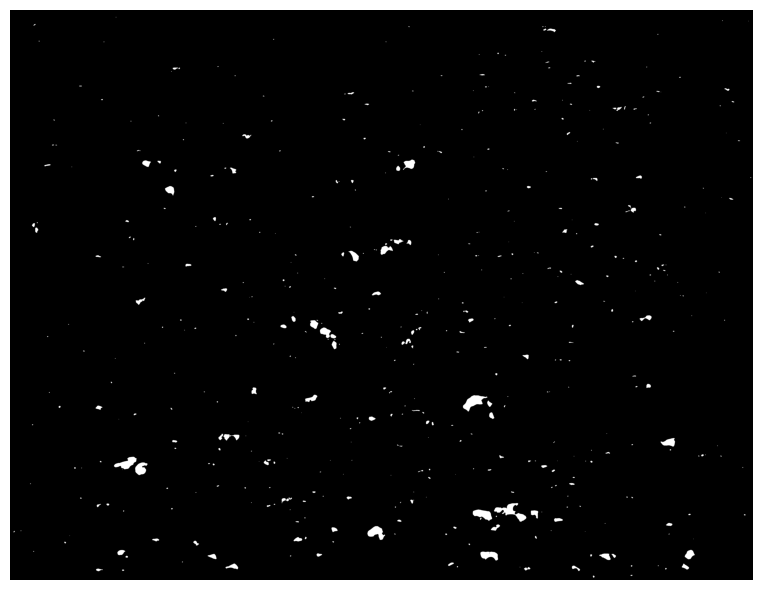

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(image_small_holes , cmap= 'gray')
ax.set_axis_off()
plt.tight_layout()

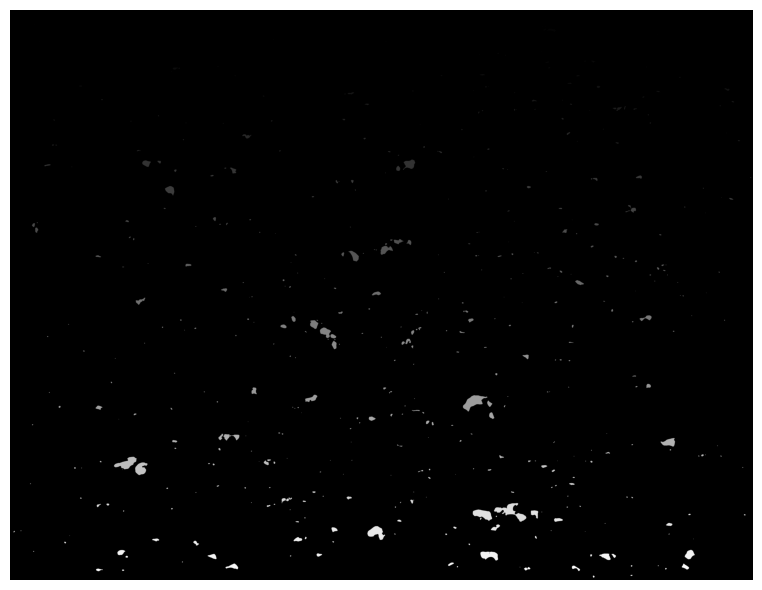

In [143]:
# save plot file name 

# label image regions
label_image = label(image_small_holes)


plt_name = os.path.join(save_fig_Dir,key + f"{key}.png")

fig, ax = plt.subplots(figsize=(10, 6))
image_label_overlay = label2rgb(label_image, image=img_gray, bg_label=0)
plt.imshow(label_image , cmap= 'grey')
ax.set_axis_off()
plt.tight_layout()
plt.savefig(plt_name)


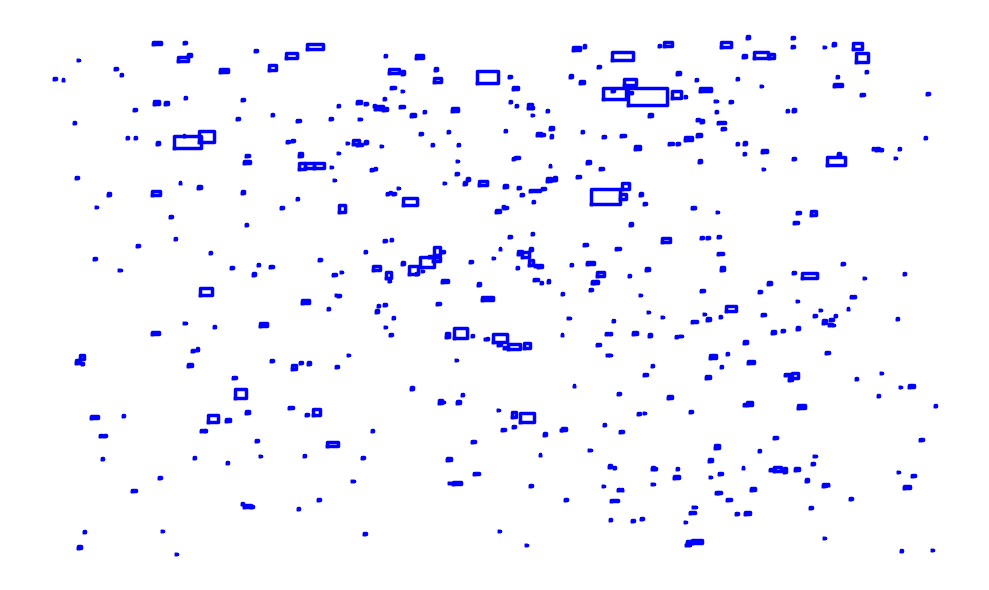

In [132]:
fig, ax = plt.subplots(figsize=(10, 6))
regions = regionprops(label_image)

for props in regions:

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [133]:
#! region props table

props = regionprops_table(label_image, properties=['label', 'area'])
data = pd.DataFrame(props)  
sum_pores_px = data.area.sum()


In [137]:
data

,label,area
0,1,8.0
1,2,12.0
2,3,5.0
3,4,61.0
4,5,25.0
...,...,...
499,500,59.0
500,501,358.0
501,502,78.0
502,503,56.0


In [134]:
#Pore ratio calculation 
w , h = image_small_holes.shape # Get the width ad the height of the images 
image_small_objects.size
n = w * h 
print(image_small_objects.size == n)

True


In [136]:

pore_ratio = 100 * (sum_pores_px / image_small_objects.size)
print(f'the width of the image is {w} and the height is {h} , the ratio is {pore_ratio}')

the width of the image is 3366 and the height is 4386 , the ratio is 0.7999308554551171


In [155]:
100*(1-(100198/image_small_objects.size))

99.32130239927778